# Project Overview

This project demonstrates the reflection pattern within an agentic AI workflow that autonomously generates and improves data visualizations.

The notebook replicates an exercise from Deeplearning.AI’s “Agentic AI” course, adapted to use a different dataset. Majority of the code in this notebook is from the “Agentic AI” course.

All supporting functionality — such as prompt handling, visualization generation, and model interaction — is implemented through a custom utils.py module that emulates the original course utilities.

# Multimodal LLM

A multi-modal LLM is a system that can take and generate outputs beyond text (image, audio, video). The LLM will review the first draft chart, identify potential improvements—such as chart type, labels, or color choices—and then rewrite the chart generation code to produce a more effective visualization.


# Agentic Workflow
1. Generate an initial version (V1): Use a Large Language Model (LLM) to create the first version of the plotting code.

2. Execute code and create chart: Run the generated code and display the resulting chart.

3. Reflect on the output: Evaluate both the code and the chart using an LLM to detect areas for improvement (ex. clarity, accuracy, design).

4. Generate and execute improved version (V2): Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

# 0. Import Packages, Load Data, and Setup

In [4]:
# Standard library imports
import re
import json
import pandas as pd

# .env
from dotenv import load_dotenv

# open ai api
from openai import OpenAI

import os

In [5]:
# load utils
import importlib, utils
importlib.reload(utils)

<module 'utils' from '/Users/chohasong/Documents/GitHub/Agentic-AI/utils.py'>

## LTV Data

In [6]:
ltv_file_path = "/Users/chohasong/Documents/GitHub/Agentic-AI/LTV_Data.xlsx"

ltv_df = utils.load_and_prepare_data_excel(
    filepath=ltv_file_path
)

[utils] Loaded dataset: /Users/chohasong/Documents/GitHub/Agentic-AI/LTV_Data.xlsx (2627 rows, 7 columns)


/Users/chohasong/Documents/GitHub/Agentic-AI/utils.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


## HTML: Display Headers

In [8]:
# ---------- Display helpers ----------
try:
    from IPython.display import display, HTML, Image
except Exception:
    display = HTML = Image = None

def print_html(content: str, title: str = "Output", is_image: bool = False):
    """Display formatted HTML or images in Jupyter."""
    if display is None:
        # Fallback: plain print if not in IPython
        print(f"[{title}]\n{content}")
        return
    if is_image:
        display(HTML(f"<h3>{title}</h3>"))
        display(Image(filename=content))
    else:
        display(HTML(f"<h3>{title}</h3><pre style='white-space:pre-wrap'>{content}</pre>"))

# 1. Load Open AI API

In [9]:
# ---------- OpenAI (vision) ----------
# Uses Chat Completions with a data: URL for the image.
# Requires: pip install openai (and OPENAI_API_KEY in env)
try:
    from openai import OpenAI
    _openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
except Exception as e:
    print(f"[utils] Warning: OpenAI client not initialized ({e})")
    _openai_client = None


In [10]:
def get_response(model: str, prompt: str) -> str:
    """Simple text-only call to OpenAI chat models."""
    if _openai_client is None:
        raise RuntimeError("OpenAI client not initialized.")
    resp = _openai_client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return resp.choices[0].message.content

# 2. Generate Code to Create a Chart (V1)

In [11]:
gpt_4o_mini = "gpt-4o-mini"
o4mini = "o4-mini"
gpt5 = "gpt-5"

In [12]:
def generate_chart_code_LTV(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'ltv df' with these columns:
    - 'Cookie ID'
    - 'Session ID' 
    - 'Email'
    - 'Purchase Date' (example: '2022-08-19')
    - 'Origin Channel'
    - 'Landing Page Type'
    - 'Purchase Value'

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'ltv df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = get_response(model, prompt)
    return response

In [13]:
# Generate initial code
code_v1_ltv = generate_chart_code_LTV(
    instruction="Create a plot comparing Purchase Value by Origin Channel by Month in ltv_df data.", 
    model=gpt_4o_mini, 
    out_path_v1="ltv_chart_v1.png"
)

print_html(code_v1_ltv)

# 3. Execute Code and Create Chart

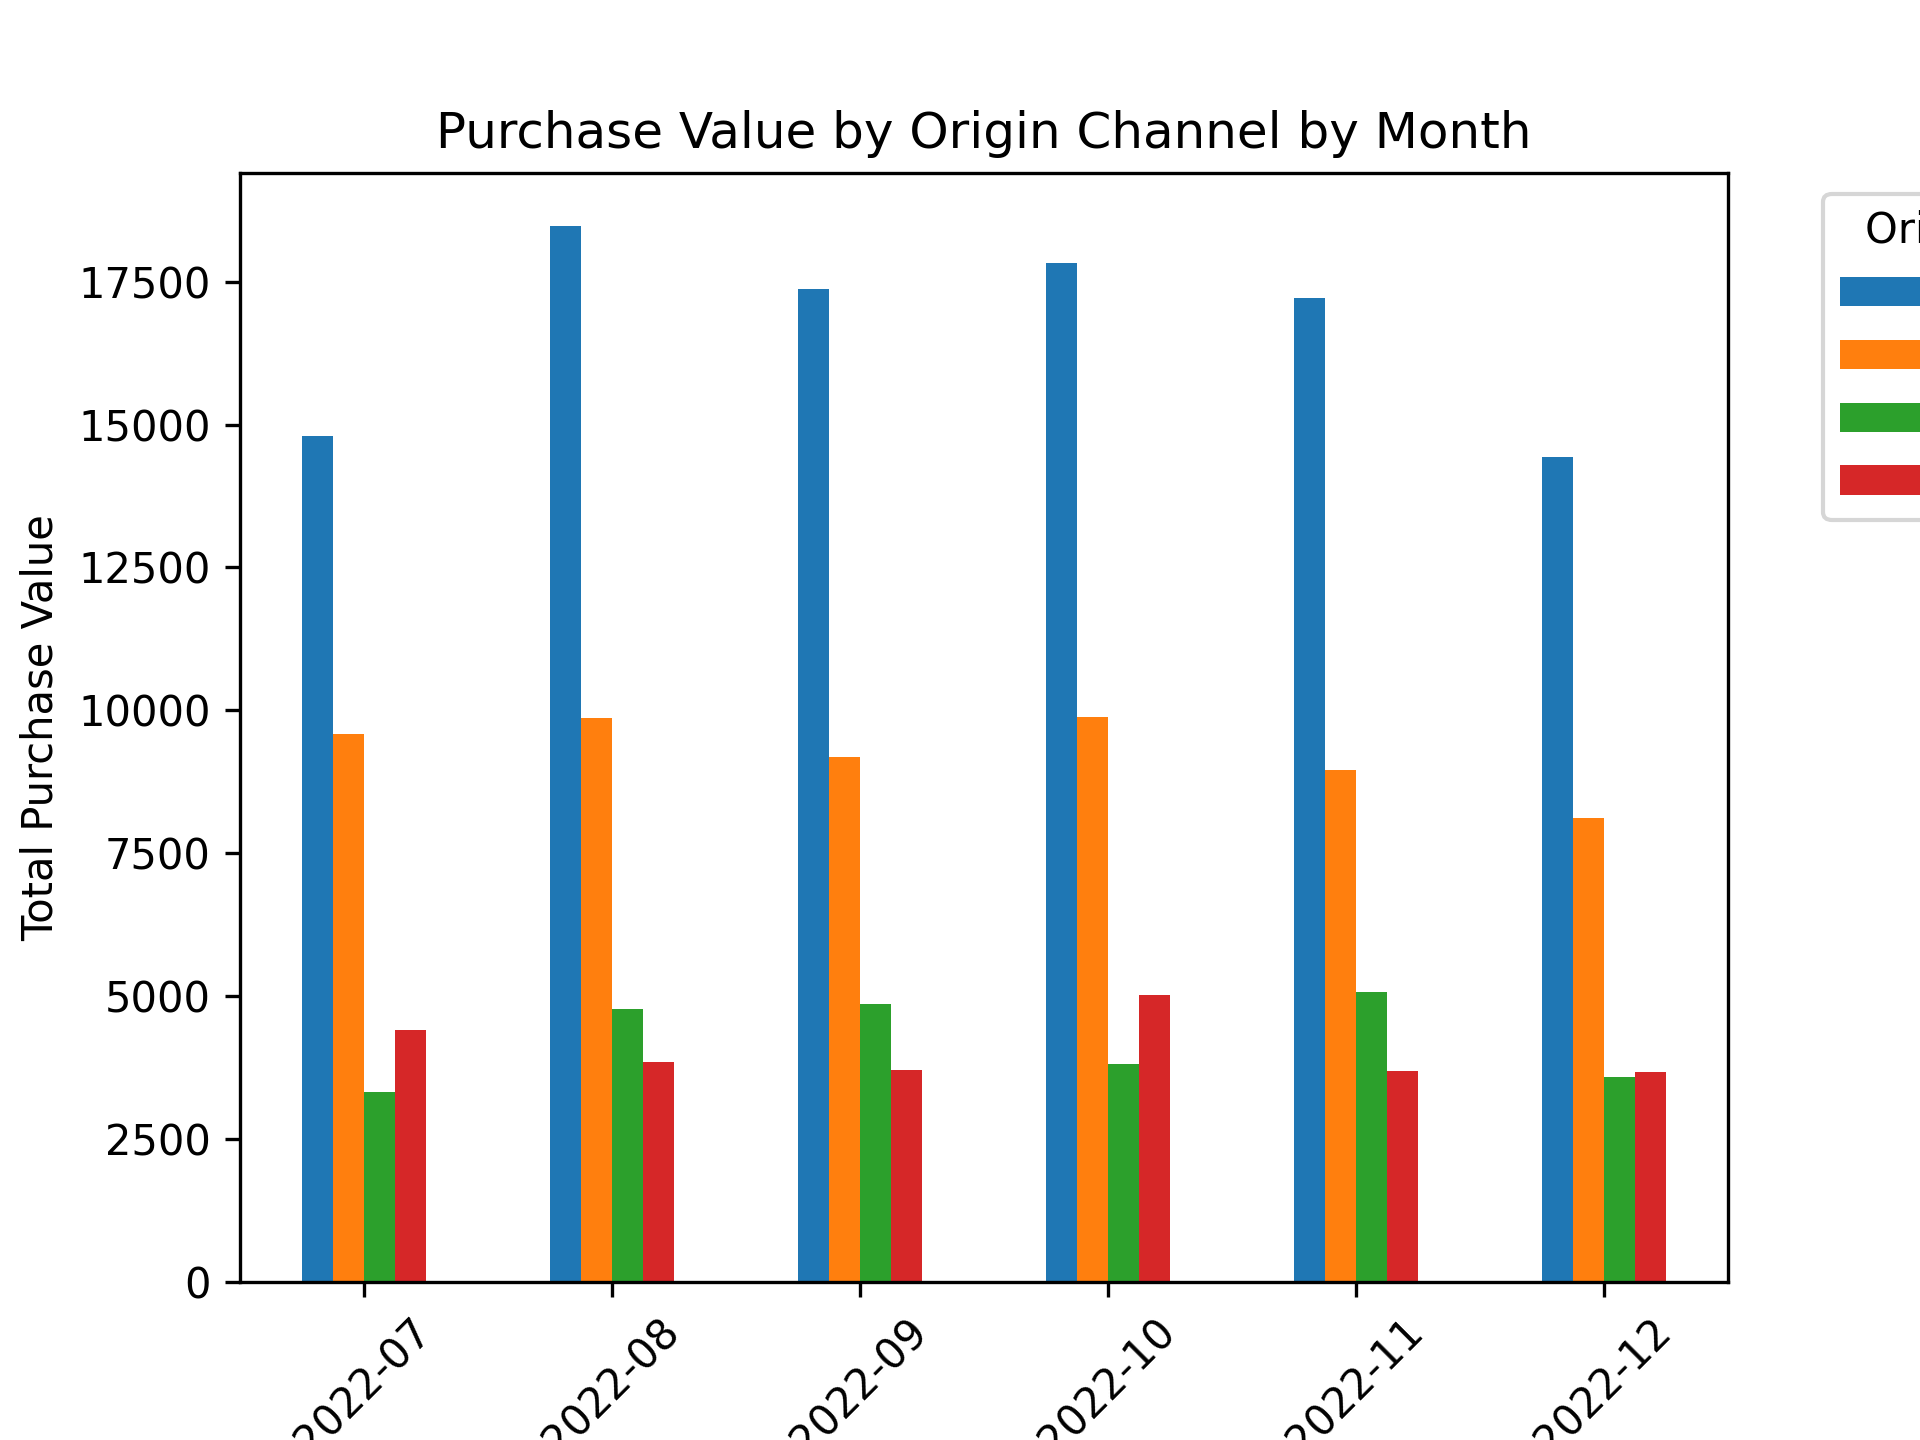

<Figure size 1200x600 with 0 Axes>

In [14]:
# Get the code within the <execute_python> tags
match_ltv = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1_ltv)
if match_ltv:
    initial_code_ltv = match_ltv.group(1).strip()
    print_html(initial_code_ltv, title="Extracted Code to Execute")
    exec_globals_ltv = {"ltv_df": ltv_df}
    exec(initial_code_ltv, exec_globals_ltv)

# If code run successfully, the file chart_v1.png should have been generated
print_html(
    content="ltv_chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

# 4. Reflect on the output

The goal here is to simulate how a human would review a first draft of a chart—looking for strengths, weaknesses, and areas for improvement.

Here’s what happens:

1. Provide the chart to the LLM: The generated chart (chart_v1.png) is shared with the LLM so it can “see” the visualization.

2. Analyze the chart visually: The LLM reviews elements like clarity, labeling, accuracy, and overall readability.

3. Generate feedback: The LLM suggests improvements—for example, fixing axis labels, adjusting the chart type, improving color choices, or highlighting missing legends.

By doing this, you create an intelligent feedback loop where the chart is not just produced once, but actively critiqued—setting the stage for a stronger second version (V2).

In [15]:
def reflect_on_image_and_regenerate_ltv(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    

    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume ltv df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in ltv df):
    - 'Cookie ID'
    - 'Session ID' 
    - 'Email'
    - 'Purchase Date' (example: '2022-08-19')
    - 'Origin Channel'
    - 'Landing Page Type'
    - 'Purchase Value'


    Instruction:
    {instruction}
    """


    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code



# 5. Generate and Execute Improved Version (V2)

In [17]:
# Generate feedback alongside reflected code
feedback_ltv, code_v2_ltv = reflect_on_image_and_regenerate_ltv(
    chart_path="ltv_chart_v1.png",            
    instruction="Create a plot comparing Purchase Value by Origin Channel by Month in ltv_df data.", 
    model_name=gpt_4o_mini,
    out_path_v2="ltv_chart_v2.png",
    code_v1=code_v1_ltv   # pass in the original code for context        
)

utils.print_html(feedback_ltv, title="Feedback on V1 Chart")
utils.print_html(code_v2_ltv, title="Regenerated Code Output (V2)")

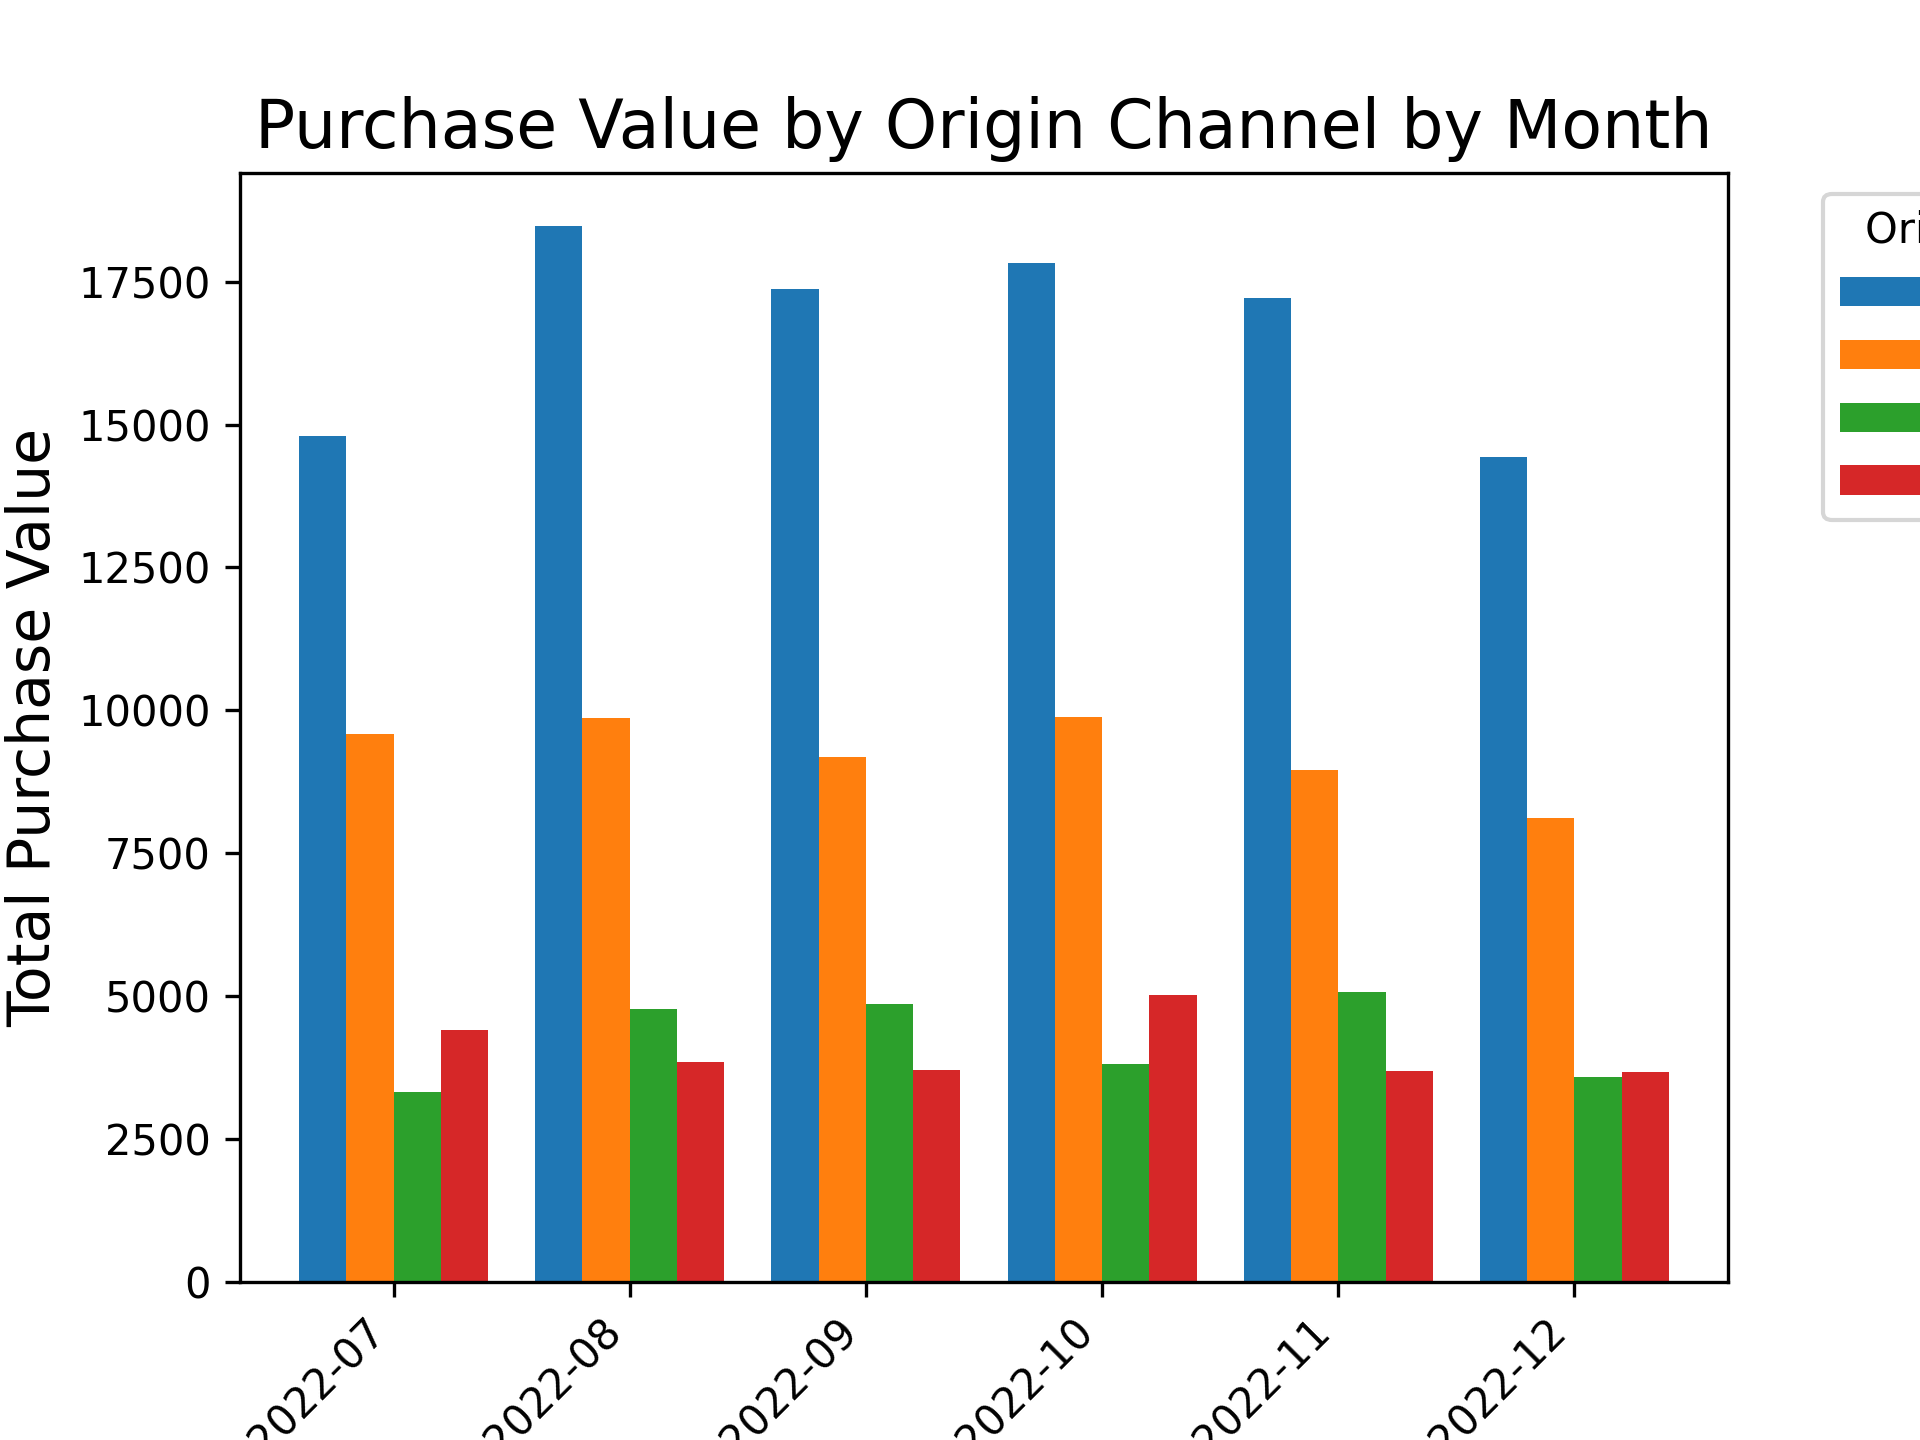

<Figure size 1400x700 with 0 Axes>

In [18]:
# Get the code within the <execute_python> tags
match_ltv = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2_ltv)
if match_ltv:
    reflected_code_ltv = match_ltv.group(1).strip()
    exec_globals_ltv = {"ltv_df": ltv_df}
    exec(reflected_code_ltv, exec_globals_ltv)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="ltv_chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

# 6. E2E Agentic Workflow

In [19]:
def run_workflow_ltv(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """

        # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    ltv_df = utils.load_and_prepare_data_excel(dataset_path)
    utils.print_html(ltv_df.sample(n=5), title="Monthly Page Visits")

        # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"


    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code_LTV(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"ltv_df": ltv_df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate_ltv(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"ltv_df": ltv_df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }


[utils] Loaded dataset: /Users/chohasong/Documents/GitHub/Agentic-AI/LTV_Data.xlsx (2627 rows, 7 columns)


/Users/chohasong/Documents/GitHub/Agentic-AI/utils.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


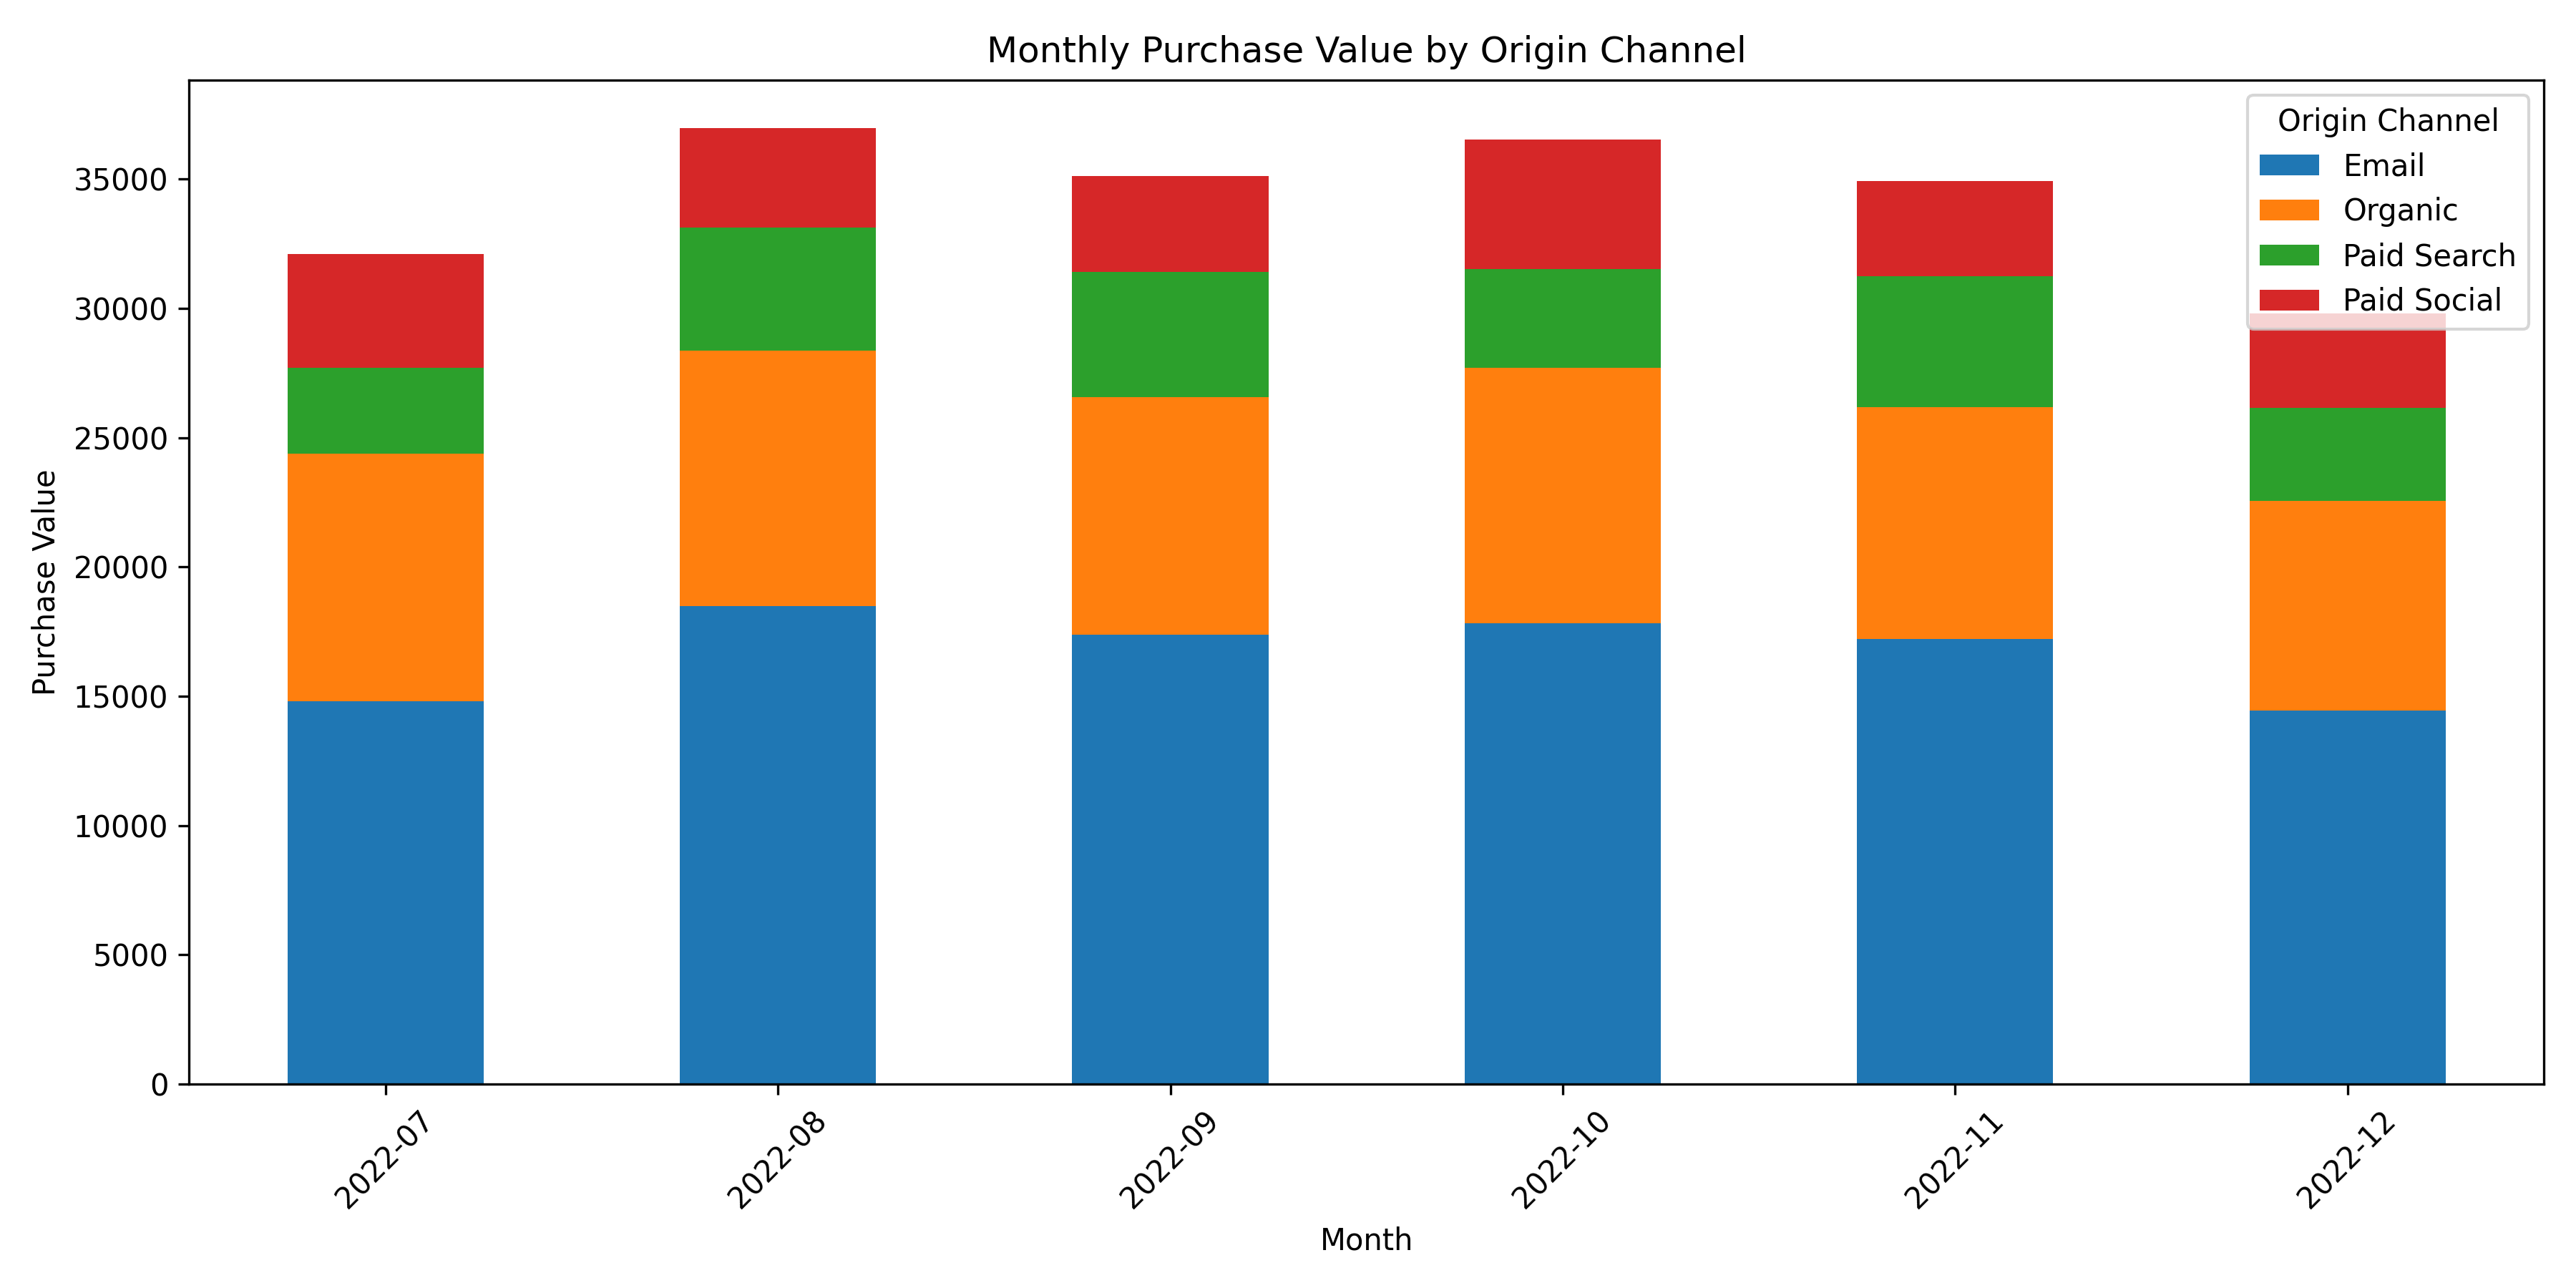

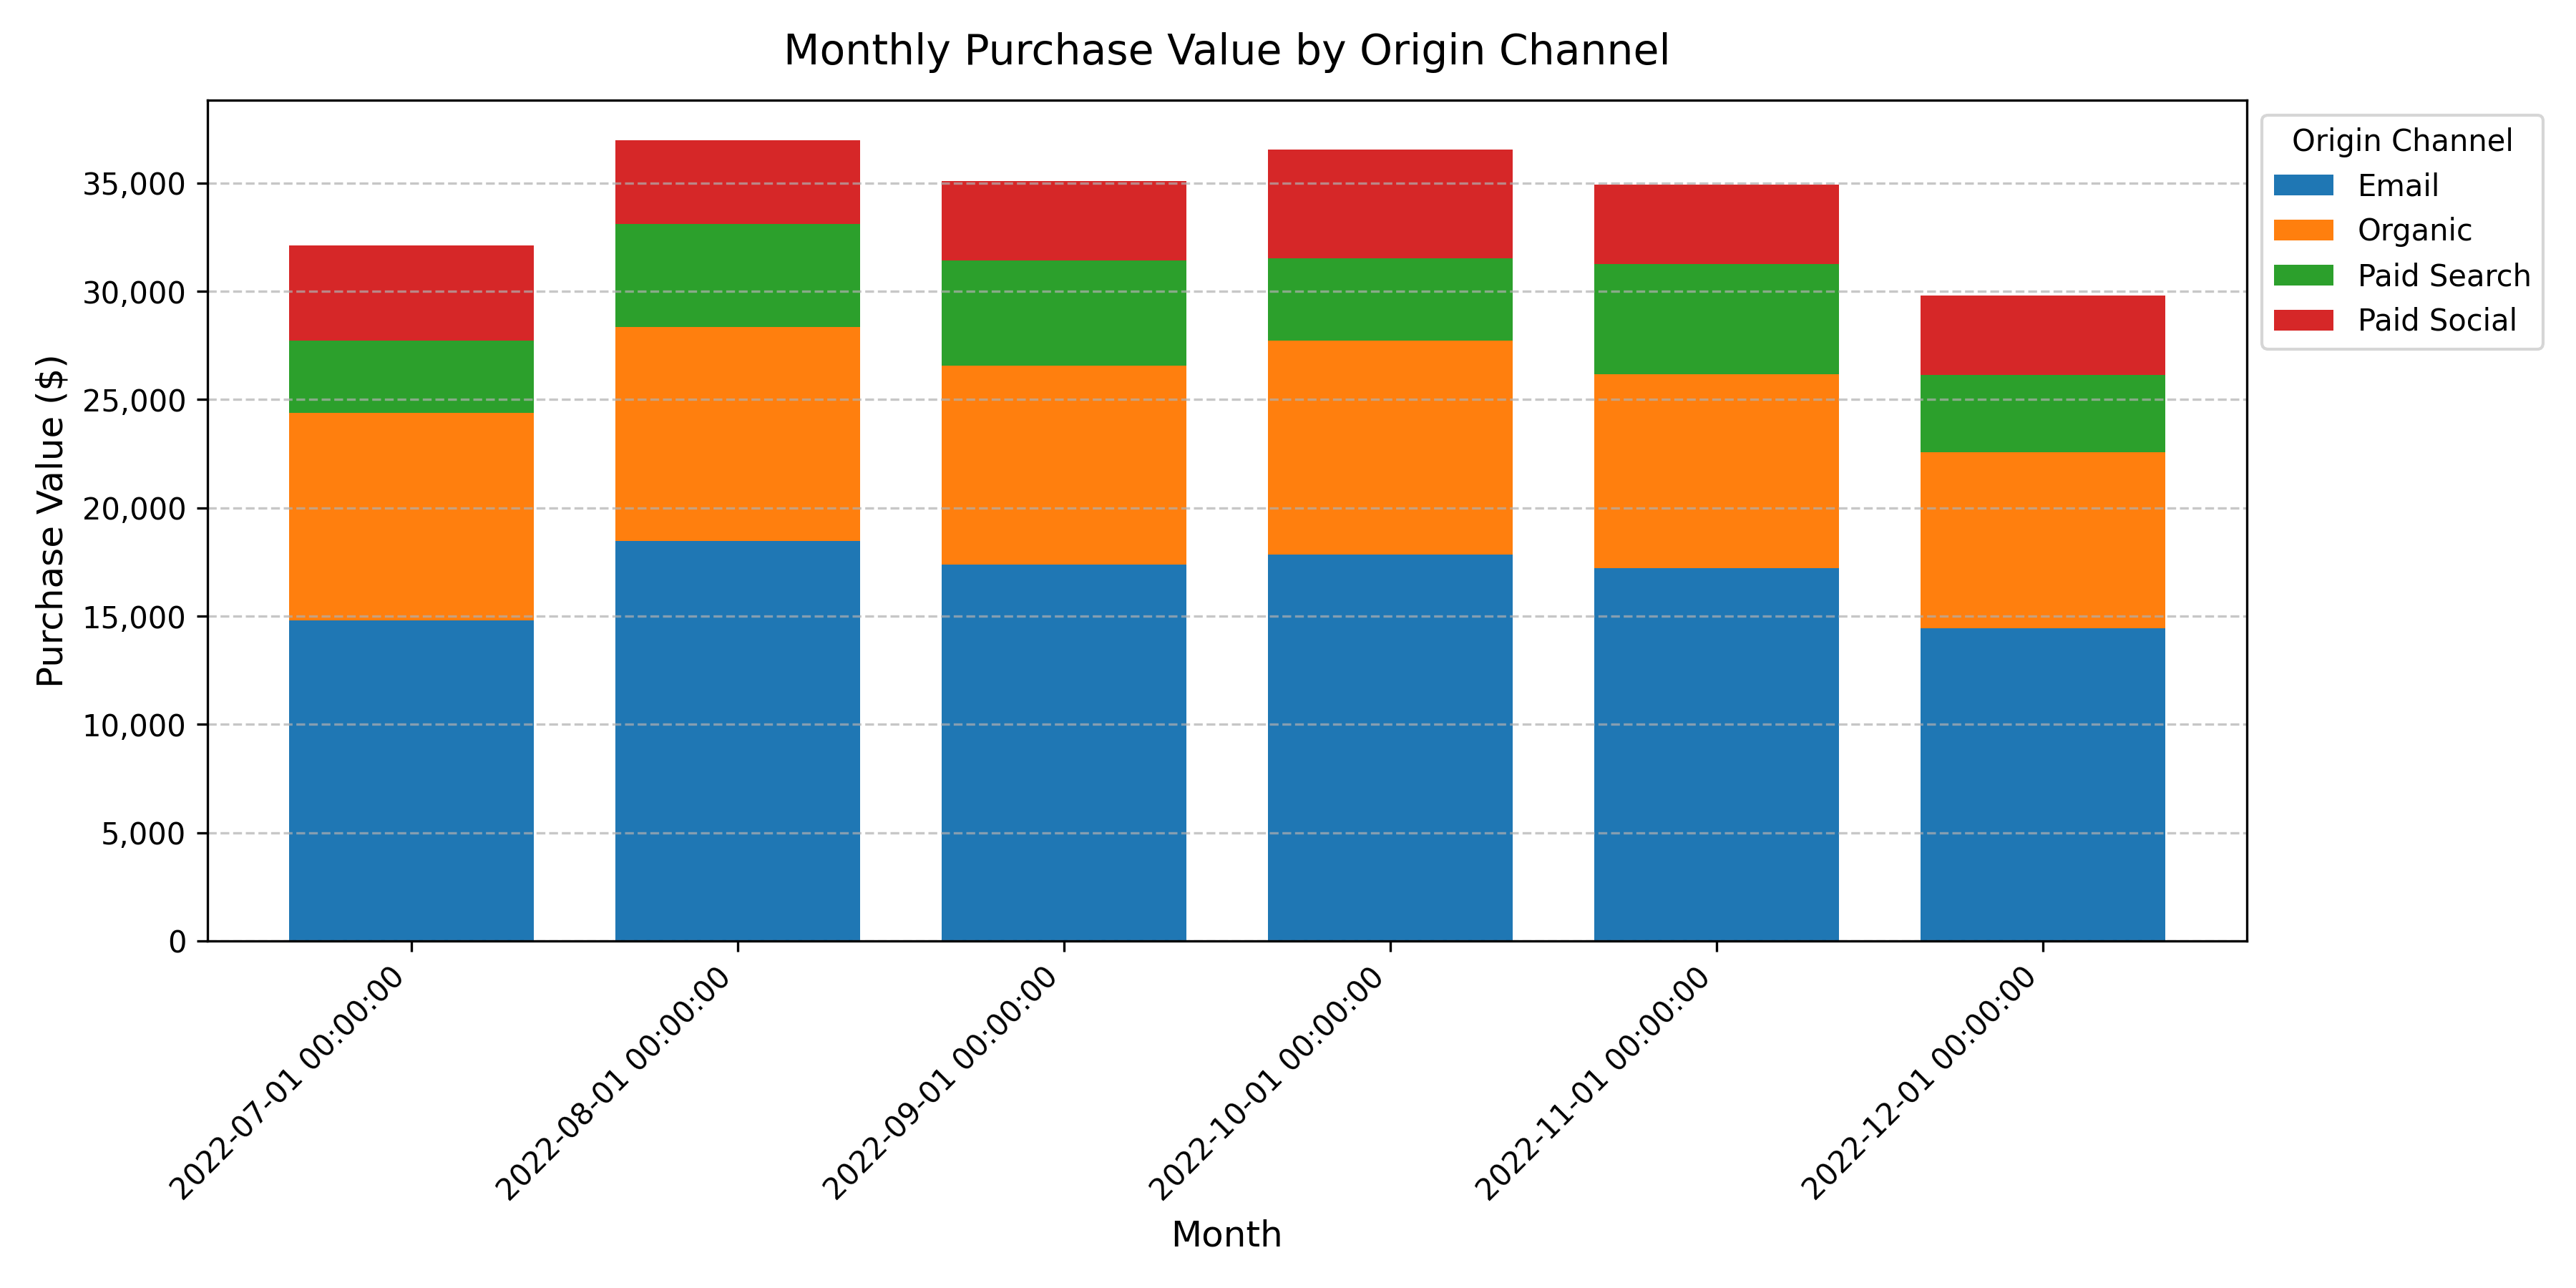

In [20]:
# Here, insert your updates
user_instructions="Create a plot comparing Purchase Value by Origin Channel by Month in ltv_df data." # write your instruction here
generation_model=gpt_4o_mini
reflection_model=o4mini
image_basename="monthly_ltv"

# Run the complete agentic workflow
_ = run_workflow_ltv(
    dataset_path=ltv_file_path,
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)